In [13]:
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_PATH = "/content/gdrive/My Drive/"
!pip install opencv-python==3.4.2.16 && pip install opencv-contrib-python==3.4.2.16
import cv2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


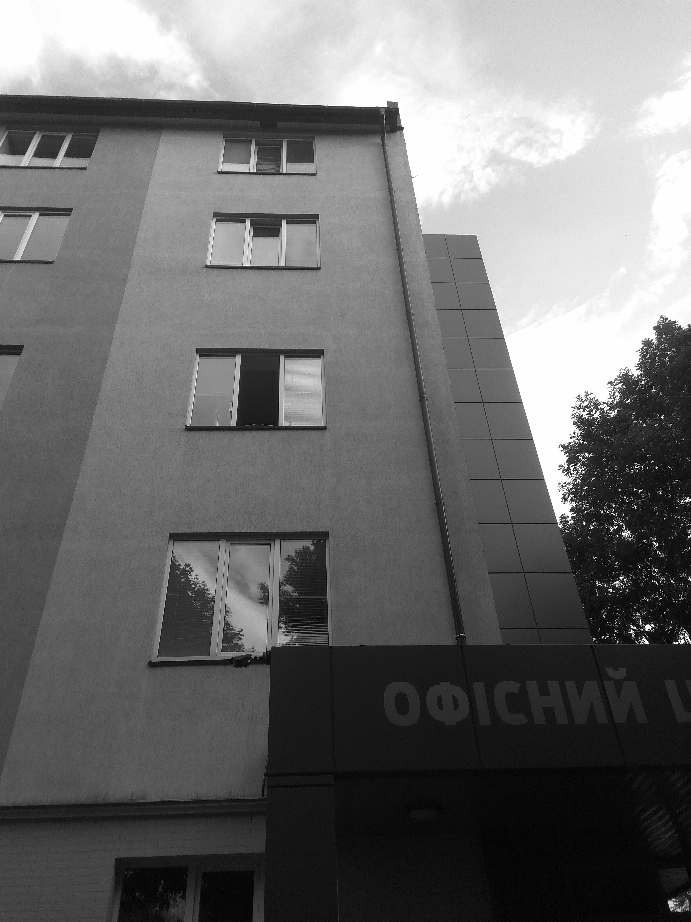

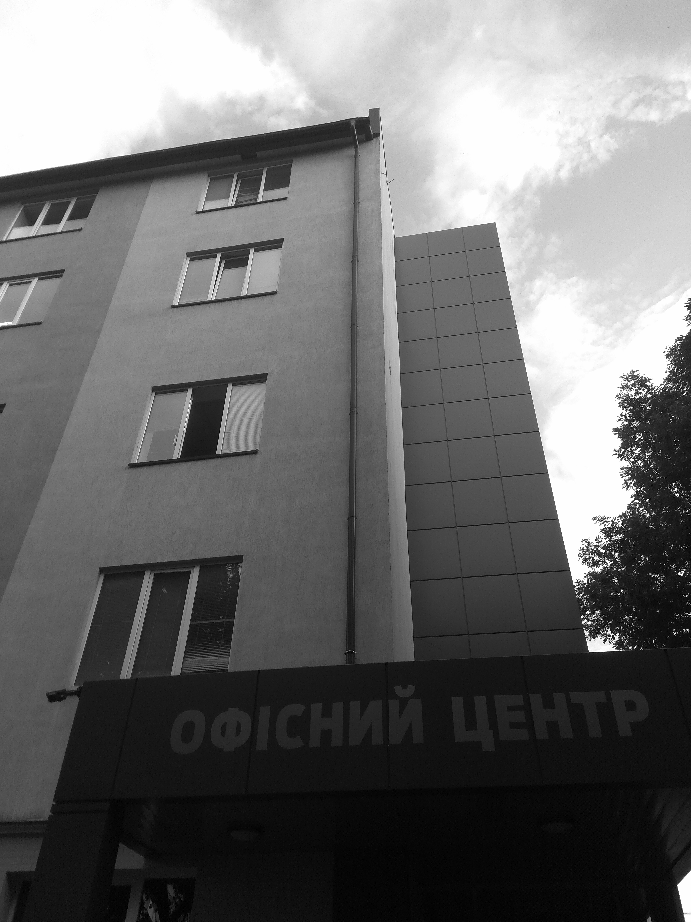

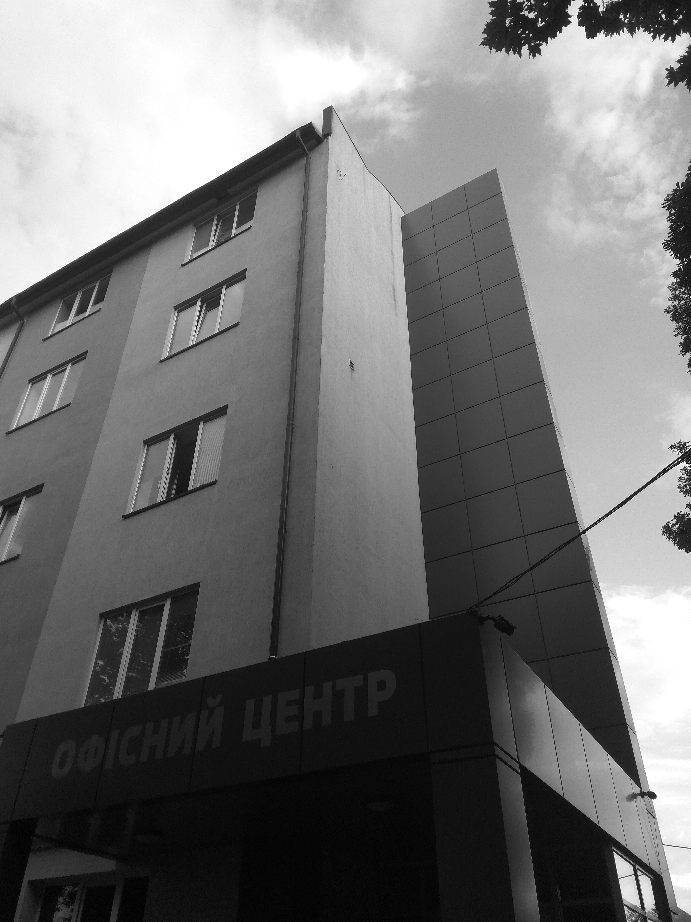

In [14]:
img1 = cv2.imread(DRIVE_PATH + 'pos1.jpg',0)
img2 = cv2.imread(DRIVE_PATH + 'pos2.jpg',0)
img3 = cv2.imread(DRIVE_PATH + 'pos3.jpg',0)
#Let's look at the pictures
cv2_imshow(cv2.resize(img1, (0,0), fx=0.2, fy=0.2))
cv2_imshow(cv2.resize(img2, (0,0), fx=0.2, fy=0.2))
cv2_imshow(cv2.resize(img3, (0,0), fx=0.2, fy=0.2))

In [0]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2





In [0]:
sift = cv2.xfeatures2d.SURF_create()



In [0]:
def getFundamentalMatrixAndDrowEpipolarLines(img1, img2):
  # find the keypoints and descriptors with SIFT
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None)
  # FLANN parameters
  FLANN_INDEX_KDTREE = 0
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks=50)

  flann = cv2.FlannBasedMatcher(index_params,search_params)
  matches = flann.knnMatch(des1,des2,k=2)

  good = []
  pts1 = []
  pts2 = []

  # ratio test as per Lowe's paper
  for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
      good.append(m)
      pts2.append(kp2[m.trainIdx].pt)
      pts1.append(kp1[m.queryIdx].pt)
          
  pts1 = np.int32(pts1)
  pts2 = np.int32(pts2)
  F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
  
  print("Fundamental matrix for this images:")
  print(F)

  # We select only inlier points
  pts1 = pts1[mask.ravel()==1]
  pts2 = pts2[mask.ravel()==1]
  # Find epilines corresponding to points in right image (second image) and
  # drawing its lines on left image
  lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
  lines1 = lines1.reshape(-1,3)
  img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

  # Find epilines corresponding to points in left image (first image) and
  # drawing its lines on right image
  lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
  lines2 = lines2.reshape(-1,3)
  img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

  plt.subplot(121),plt.imshow(img5)
  plt.subplot(122),plt.imshow(img3)
  plt.show()

Fundamental matrix for this images:
[[-3.93492315e-09  1.12315394e-07 -4.54791171e-04]
 [-1.81833485e-08  2.66145255e-08 -2.19213831e-03]
 [ 5.31906268e-06  1.94323590e-03  1.00000000e+00]]


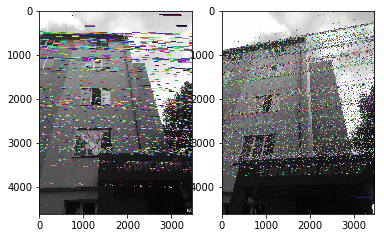

In [18]:
getFundamentalMatrixAndDrowEpipolarLines(img1, img2)

Fundamental matrix for this images:
[[ 4.85366304e-07  8.18530179e-07 -4.51474699e-04]
 [-9.93166511e-07 -2.48372014e-08  1.34429631e-03]
 [-9.63406812e-04 -1.21711705e-03  1.00000000e+00]]


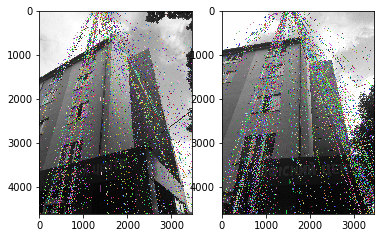

In [19]:
getFundamentalMatrixAndDrowEpipolarLines(img3, img2)

Fundamental matrix for this images:
[[ 8.69198214e-08 -4.42178500e-08  3.24268399e-04]
 [ 1.23821325e-07 -2.50601988e-08 -4.03269589e-04]
 [-9.74286561e-04  2.92454589e-04  1.00000000e+00]]


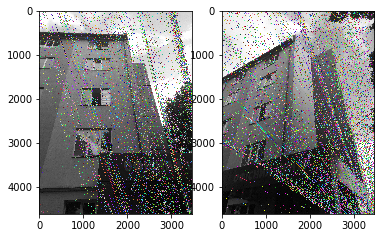

In [20]:
getFundamentalMatrixAndDrowEpipolarLines(img1, img3)